# Linear Mixed Effects Model
To predict ventricle 

In [212]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk

import datetime as dt
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf

from math import sqrt
import warnings
warnings.filterwarnings('ignore')

## Import data, get most recent diagnosis

In [213]:
outputFile = 'TADPOLE_LME_WC.csv'

tadpoleD1D2File = 'TADPOLE_D1_D2.csv'

data_tadpole = pd.read_csv(tadpoleD1D2File, low_memory=False)

#Create Diagnosis variable based on DXCHANGE
idx_mci=data_tadpole['DXCHANGE']==4
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_ad = data_tadpole['DXCHANGE']==5
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_ad = data_tadpole['DXCHANGE']==6
data_tadpole.loc[idx_ad,'DXCHANGE']=3
idx_cn = data_tadpole['DXCHANGE']==7
data_tadpole.loc[idx_cn,'DXCHANGE']=1
idx_mci=data_tadpole['DXCHANGE']==8
data_tadpole.loc[idx_mci,'DXCHANGE']=2
idx_cn = data_tadpole['DXCHANGE']==9
data_tadpole.loc[idx_cn,'DXCHANGE']=1
data_tadpole=data_tadpole.rename(columns={'DXCHANGE':'Diagnosis'})

data_tadpole['Diagnosis'] = data_tadpole.Diagnosis.astype('category')

In [214]:
data_tadpole.head(30)

,RID,PTID,VISCODE,SITE,D1,D2,COLPROT,ORIGPROT,EXAMDATE,DX_bl,...,PHASE_UPENNBIOMK9_04_19_17,BATCH_UPENNBIOMK9_04_19_17,KIT_UPENNBIOMK9_04_19_17,STDS_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17,update_stamp_UPENNBIOMK9_04_19_17
0,2,011_S_0002,bl,11,1,1,ADNI1,ADNI1,2005-09-08,CN,...,,,,,,,,,,
1,3,011_S_0003,bl,11,1,0,ADNI1,ADNI1,2005-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,741.5,239.7,22.83,NaN,2017-04-20 14:39:54.0
2,3,011_S_0003,m06,11,1,0,ADNI1,ADNI1,2006-03-13,AD,...,,,,,,,,,,
3,3,011_S_0003,m12,11,1,0,ADNI1,ADNI1,2006-09-12,AD,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2016-12-14,601.4,251.7,24.18,NaN,2017-04-20 14:39:54.0
4,3,011_S_0003,m24,11,1,0,ADNI1,ADNI1,2007-09-12,AD,...,,,,,,,,,,
5,4,022_S_0004,bl,22,1,0,ADNI1,ADNI1,2005-11-08,LMCI,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2017-01-09,1501,153.1,13.29,NaN,2017-04-20 14:39:54.0
6,4,022_S_0004,m06,22,1,0,ADNI1,ADNI1,2006-05-02,LMCI,...,,,,,,,,,,
7,4,022_S_0004,m12,22,1,0,ADNI1,ADNI1,2006-11-14,LMCI,...,ADNI1,UPENNBIOMK9,P06-MP02-MP01,P06-MP02-MP01/2,2017-01-09,1176,159.7,13.3,NaN,2017-04-20 14:39:54.0
8,4,022_S_0004,m18,22,1,0,ADNI1,ADNI1,2007-05-14,LMCI,...,,,,,,,,,,
9,4,022_S_0004,m36,22,1,0,ADNI1,ADNI1,2008-11-18,LMCI,...,,,,,,,,,,


## Get list of D2 individuals we want to predict

In [215]:
D2=data_tadpole['D2'].copy()
#Make list of RIDs in D2 to be predicted
idx_d2=D2==1
data_tadpole_RID = data_tadpole.loc[idx_d2,'RID']
SD2=pd.Series(np.unique(data_tadpole_RID.values))
SD2.to_csv('ToPredict_D2.csv',index=False)

## Make new dataframe with less variables
Ventricles, Hippocampus, Entorhinal, Fusiform, MidTemp, WholeBrain
MMSE, RAVLT_immediate, ADAS13, FAQ, CDRSB


In [216]:
data_interest=data_tadpole[['RID','VISCODE','D1','D2','EXAMDATE','PTGENDER','PTEDUCAT','PTETHCAT',
                    'PTRACCAT','PTMARRY','Diagnosis','AGE','APOE4','FDG','PIB','AV45',
                    'Ventricles','Hippocampus','Entorhinal','Fusiform','MidTemp','WholeBrain','ICV_bl',
                    'MMSE','RAVLT_immediate','ADAS13','FAQ','CDRSB','Month_bl','Years_bl','Ventricles_bl','DX_bl']].copy()

data_interest.head()

,RID,VISCODE,D1,D2,EXAMDATE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,ICV_bl,MMSE,RAVLT_immediate,ADAS13,FAQ,CDRSB,Month_bl,Years_bl,Ventricles_bl,DX_bl
0,2,bl,1,1,2005-09-08,Male,16,Not Hisp/Latino,White,Married,...,1984660.0,28.0,44.0,18.67,0.0,0.0,0.00000,0.000000,118233.0,CN
1,3,bl,1,0,2005-09-12,Male,18,Not Hisp/Latino,White,Married,...,1920690.0,20.0,22.0,31.00,10.0,4.5,0.00000,0.000000,84599.0,AD
2,3,m06,1,0,2006-03-13,Male,18,Not Hisp/Latino,White,Married,...,1920690.0,24.0,19.0,30.00,12.0,6.0,5.96721,0.498289,84599.0,AD
3,3,m12,1,0,2006-09-12,Male,18,Not Hisp/Latino,White,Married,...,1920690.0,17.0,31.0,35.00,17.0,3.5,11.96720,0.999316,84599.0,AD
4,3,m24,1,0,2007-09-12,Male,18,Not Hisp/Latino,White,Married,...,1920690.0,19.0,23.0,37.67,14.0,8.0,23.93440,1.998630,84599.0,AD


## Correct structural vols for IVC
Ventricles, Hippocampus, Entorhinal, Fusiform, MidTemp, WholeBrain 

In [217]:
data_interest['Ventricles_ICV'] = data_interest['Ventricles'].values / data_interest['ICV_bl'].values
data_interest['Ventricles_bl_ICV'] = data_interest['Ventricles_bl'].values / data_interest['ICV_bl'].values
data_interest['Hippocampus_ICV'] = data_interest['Hippocampus'].values / data_interest['ICV_bl'].values
data_interest['Entorhinal_ICV'] = data_interest['Entorhinal'].values / data_interest['ICV_bl'].values
data_interest['Fusiform_ICV'] = data_interest['Fusiform'].values / data_interest['ICV_bl'].values
data_interest['MidTemp_ICV'] = data_interest['MidTemp'].values / data_interest['ICV_bl'].values
data_interest['WholeBrain_ICV'] = data_interest['WholeBrain'].values / data_interest['ICV_bl'].values

## Look at some correlations

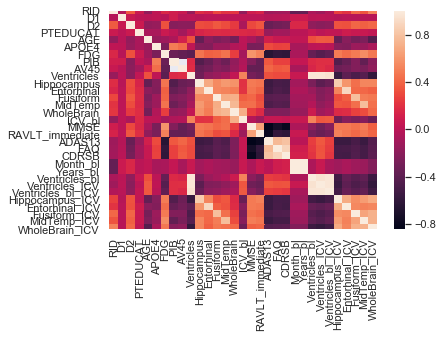

In [218]:
corr = data_interest.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Drop missing
Commented out, deal with in model formula 

In [219]:
data_interest.dropna(subset = ['RID', 'Ventricles','Hippocampus_ICV','Entorhinal_ICV','Fusiform_ICV','MidTemp_ICV','WholeBrain_ICV','ICV_bl'],how='any',inplace=True)

## Calculate VISIT AGE

In [220]:
data_interest['VISITAGE'] = data_interest['AGE'] + data_interest['Years_bl']

## Work out time to forecast

In [221]:
# * Compute months since Jan 2000 for each exam date
ref = dt.datetime(2000, 1, 1)
EXAMDATE = data_interest.EXAMDATE.values.copy()
ExamMonth_Col = np.zeros(len(EXAMDATE))
for k in range(0, len(EXAMDATE)):
  d = dt.datetime.strptime(EXAMDATE[k], '%Y-%m-%d') - ref
  ExamMonth_Col[k] = d.days / 365 * 12

## Try a simple linear mixed effects model
 - Ventricles_ICV as dependent
 - Time (months from baseline), random intercepts and slopes for each individual

In [222]:
model = sm.MixedLM.from_formula("Ventricles_ICV ~ 1 + Month_bl", data_interest, groups=data_interest["RID"], re_formula="1 + Month_bl")
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Ventricles_ICV
No. Observations:  6019     Method:              REML          
No. Groups:        1594     Scale:               0.0000        
Min. group size:   1        Likelihood:          23681.4824    
Max. group size:   11       Converged:           No            
Mean group size:   3.8                                         
---------------------------------------------------------------
                     Coef. Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.025    0.000 145.014 0.000  0.025  0.026
Month_bl             0.000    0.000   9.173 0.000  0.000  0.000
Group Var            0.000    0.001                            
Group x Month_bl Cov 0.000    0.000                            
Month_bl Var         0.000                                     



## Add in covariates

### LME help:
Parameters
endog1d array_like
The dependent variable

exog2d array_like
A matrix of covariates used to determine the mean structure (the “fixed effects” covariates).

groups1d array_like
A vector of labels determining the groups – data from different groups are independent

exog_re2d array_like
A matrix of covariates used to determine the variance and covariance structure (the “random effects” covariates). If None, defaults to a random intercept for each group.

In [223]:
#add age?

#model = sm.MixedLM.from_formula("Ventricles_ICV ~ 1 + Month_bl + VISITAGE + Hippocampus_ICV + Entorhinal_ICV + Fusiform_ICV + MidTemp_ICV + WholeBrain_ICV", data_interest, groups=data_interest["RID"], re_formula="~Month_bl")
#result = model.fit()
#print(result.summary())


#NEST by group amyloid +/-

model= sm.MixedLM.from_formula('Ventricles_ICV ~ 1 + Month_bl + VISITAGE + Hippocampus_ICV + Entorhinal_ICV + Fusiform_ICV + MidTemp_ICV + WholeBrain_ICV', re_formula='1 + Month_bl', groups='RID', data=data_interest)
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Ventricles_ICV
No. Observations:   6019    Method:             REML          
No. Groups:         1594    Scale:              0.0000        
Min. group size:    1       Likelihood:         25173.8764    
Max. group size:    11      Converged:          Yes           
Mean group size:    3.8                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           0.053    0.003  19.948 0.000  0.048  0.058
Month_bl            0.000    0.000   6.960 0.000  0.000  0.000
VISITAGE            0.000    0.000  15.956 0.000  0.000  0.000
Hippocampus_ICV    -3.640    0.195 -18.700 0.000 -4.022 -3.259
Entorhinal_ICV     -0.299    0.151  -1.973 0.048 -0.595 -0.002
Fusiform_ICV       -0.346    0.074  -4.662 0.000 -0.491 -0.200
MidTe

Get parameters some other parameters

In [224]:
print('Parameters: ', result.params['Month_bl'])
print('Standard errors: ', result.bse)
print('Predicted values: ', result.predict())

Parameters:  6.53060578345543e-05
Standard errors:  Intercept             0.002642
Month_bl              0.000009
VISITAGE              0.000022
Hippocampus_ICV       0.194669
Entorhinal_ICV        0.151315
Fusiform_ICV          0.074147
MidTemp_ICV           0.073495
WholeBrain_ICV        0.003313
RID Var               0.239243
RID x Month_bl Cov    0.012118
Month_bl Var               NaN
dtype: float64
Predicted values:  [0.03025733 0.03985913 0.04102441 ... 0.02521054 0.0180543  0.02378008]


Get confidence intervals

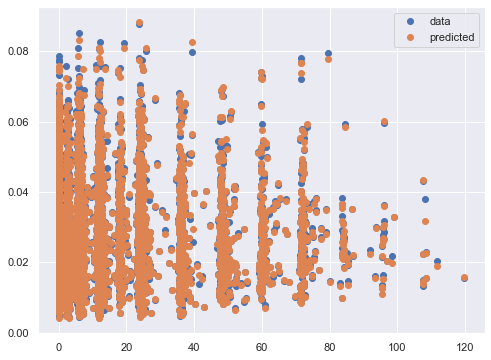

In [225]:
fig, ax = plt.subplots(figsize=(8,6))
x=data_interest["Month_bl"]
ax.plot(x, data_interest["Ventricles_ICV"], 'o', label="data")
ax.plot(x, result.fittedvalues, 'o', label="predicted")
#ax.plot(x, iv_u, 'r--')
#ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');

In [226]:
result.conf_int(0.5)

,0,1
Intercept,0.050913,0.054476
Month_bl,0.000059,0.000072
VISITAGE,0.000336,0.000365
Hippocampus_ICV,-3.771559,-3.508954
Entorhinal_ICV,-0.400660,-0.196539
Fusiform_ICV,-0.395694,-0.295672
MidTemp_ICV,-0.048096,0.051048
WholeBrain_ICV,-0.050147,-0.045678
RID Var,9.993388,10.316122
RID x Month_bl Cov,0.081494,0.097842


## Make forecasts

In [227]:
# * Create arrays to contain the 60 monthly forecasts for each D2 subject
nForecasts = 5 * 12  # forecast 5 years (60 months).

# * Submission dates - compare with submission template
startDate = dt.datetime(2018, 1, 1)
endDate = startDate + relativedelta(months=+nForecasts - 1)

## Generate the very simple forecast
# * Get the list of subjects to forecast from LB2 - the ordering is the
# * same as in the submission template.
D2_SubjList = D2
N_D2 = len(D2_SubjList)

# 1. Clinical status forecasts
#    i.e. relative likelihood of NL, MCI, and Dementia (3 numbers)
#CLIN_STAT_forecast = np.zeros([N_D2, nForecasts, 3])
# 2. ADAS13 forecasts
#    (best guess, upper and lower bounds on 50% confidence interval)
#ADAS13_forecast = np.zeros([N_D2, nForecasts, 3])
# 3. Ventricles volume forecasts
#    (best guess, upper and lower bounds on 50% confidence interval)
Ventricles_ICV_forecast = np.zeros([N_D2, nForecasts, 3])

Ventricles_ICV_forecast

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

## Bootstrap 50% CI 

In [228]:
from numpy import mean
from numpy import median
from numpy import percentile
# bootstrap
#dataset = result.predict()
dataset = data_interest["Ventricles_ICV"] #need to set to 
# configure bootstrap
n_iterations = 1000 #set low for testing
n_size = int(len(dataset) * 0.50)
total_size = int(len(dataset))

scores = list()
for _ in range(n_iterations):
    # bootstrap sample
    indices = randint(0, total_size, n_size)
    sample = dataset[indices]
    # calculate and store statistic
    statistic = mean(sample)
    scores.append(statistic)
print('50th percentile (median) = %.3f' % median(scores))
# calculate 50% confidence intervals (100 - alpha)
alpha = 50.0
# calculate lower percentile (e.g. 25)
lower_p = alpha / 2.0
# retrieve observation at lower percentile
lower = max(0.0, percentile(scores, lower_p))
print('%.1fth percentile = %.3f' % (lower_p, lower))
# calculate upper percentile (e.g. 75)
upper_p = (100 - alpha) + (alpha / 2.0)
# retrieve observation at upper percentile
upper = min(1.0, percentile(scores, upper_p))
print('%.1fth percentile = %.3f' % (upper_p, upper))

50th percentile (median) = 0.026
25.0th percentile = 0.026
75.0th percentile = 0.027


## Create submission table

In [229]:
## Now construct the forecast spreadsheet and output it.
print('Constructing the output spreadsheet {0} ...'.format(outputFile))
submission_table = pd.DataFrame()
# * Repeated matrices - compare with submission template
submission_table['RID'] = D2_SubjList.repeat(nForecasts)
submission_table['ForecastMonth'] = np.tile(range(1, nForecasts + 1), (N_D2, 1)).flatten()

ForecastDates = [startDate]
while ForecastDates[-1] < endDate:
  ForecastDates.append(ForecastDates[-1] + relativedelta(months=+1))
ForecastDatesStrings = [dt.datetime.strftime(d, '%Y-%m') for d in ForecastDates]
submission_table['ForecastDate'] = np.tile(ForecastDatesStrings, (N_D2, 1)).flatten()
# * Pre-fill forecast data, encoding missing data as NaN
nanColumn = np.repeat(np.nan, submission_table.shape[0])
#submission_table['CNRelativeProbability'] = nanColumn
#submission_table['MCIRelativeProbability'] = nanColumn
#submission_table['ADRelativeProbability'] = nanColumn
#submission_table['ADAS13'] = nanColumn
#submission_table['ADAS1350_CILower'] = nanColumn
#submission_table['ADAS1350_CIUpper'] = nanColumn
submission_table['Ventricles_ICV'] = nanColumn
submission_table['Ventricles_ICV50_CILower'] = nanColumn
submission_table['Ventricles_ICV50_CIUpper'] = nanColumn

submission_table.rename(columns={'RID': 'RID',
                                 'ForecastMonth': 'Forecast Month',
                                 'ForecastDate': 'Forecast Date',
                                 #'CNRelativeProbability': 'CN relative probability',
                                 #'MCIRelativeProbability': 'MCI relative probability',
                                 #'ADRelativeProbability': 'AD relative probability',
                                 #'ADAS13': 'ADAS13',
                                 #'ADAS1350_CILower': 'ADAS13 50% CI lower',
                                 #'ADAS1350_CIUpper': 'ADAS13 50% CI upper',
                                 'Ventricles_ICV': 'Ventricles_ICV',
                                 'Ventricles_ICV50_CILower': 'Ventricles_ICV 50% CI lower',
                                 'Ventricles_ICV50_CIUpper': 'Ventricles_ICV 50% CI upper'}, inplace=True)
# * Write to file
submission_table.to_csv(outputFile, index=False)


Constructing the output spreadsheet TADPOLE_LME_WC.csv ...
